In [1]:
import os
import gc
import json
import torch
import datetime
import threading

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import concurrent.futures
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [46]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

[None, None, None, None, None, None, None, None]

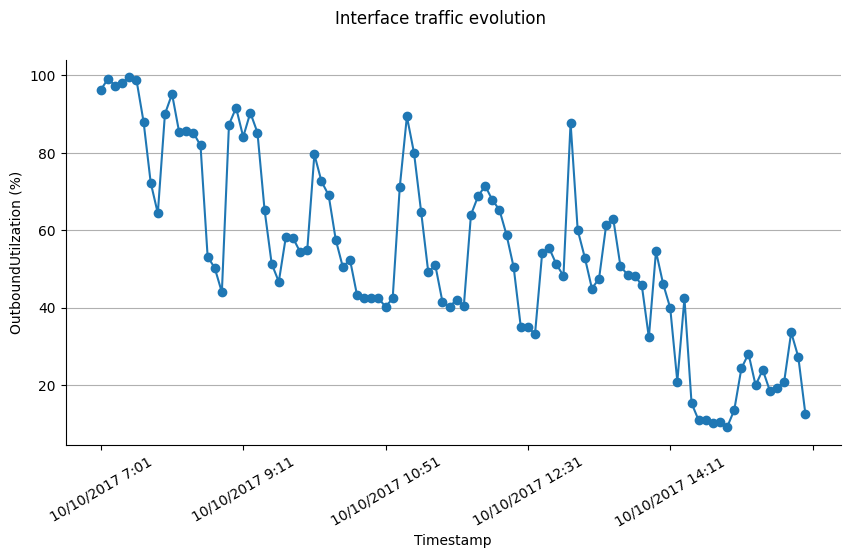

In [3]:
x = network_analytics['Timestamp'][:100]
y = network_analytics['OutboundUtilzation (%)'][:100]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, marker='o')

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')
ax.set_xlabel('Timestamp')

ax.grid(True, axis='y')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[lab.set_rotation(30) for lab in ax.get_xticklabels()]

In [4]:
print(network_analytics['Timestamp'].max())
print(network_analytics['Timestamp'].min())
print(datetime.datetime.strptime(network_analytics['Timestamp'][len(network_analytics) - 1], '%d/%m/%Y %H:%M') - datetime.datetime.strptime(network_analytics['Timestamp'][0], '%d/%m/%Y %H:%M'))

12/9/2017 9:57
1/1/2018 0:02
295 days, 6:06:00


In [5]:
network_analytics.describe()

,OutboundUtilzation (%)
count,25631.000000
mean,60.372335
std,22.517275
min,0.000048
25%,44.873850
50%,62.100200
75%,77.702150
max,99.995500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


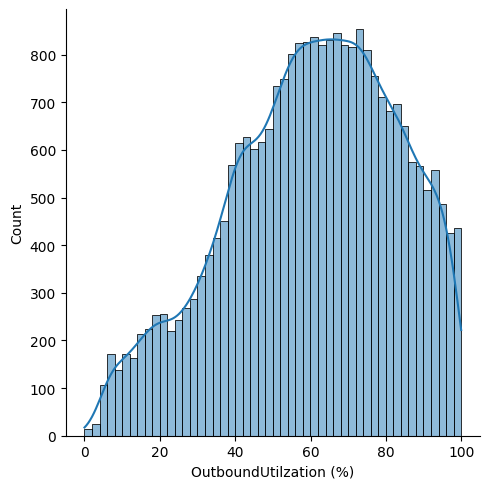

In [6]:
sns.displot(network_analytics['OutboundUtilzation (%)'], kde=True, bins=50)

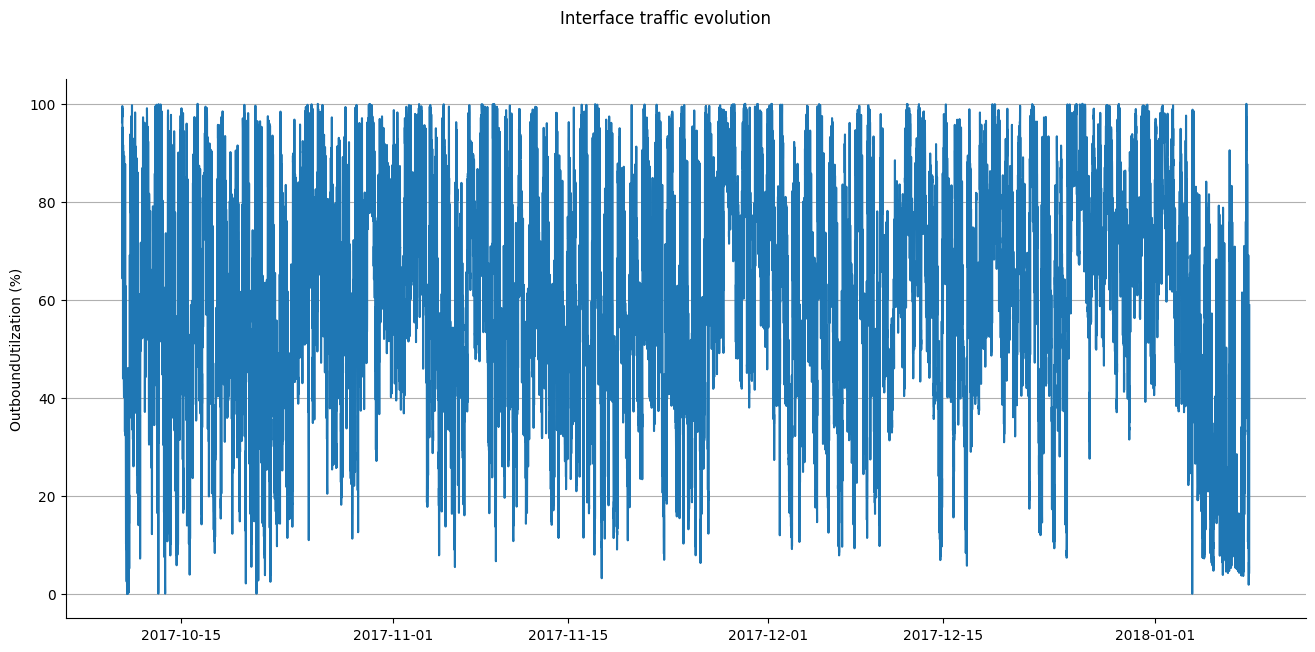

In [7]:
network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
network_analytics_new = network_analytics.set_index('Timestamp')
network_analytics_new.rename(columns={'OutboundUtilzation (%)':'traffic_out'},inplace=True)  

x = network_analytics_new.index
y = network_analytics_new['traffic_out']

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

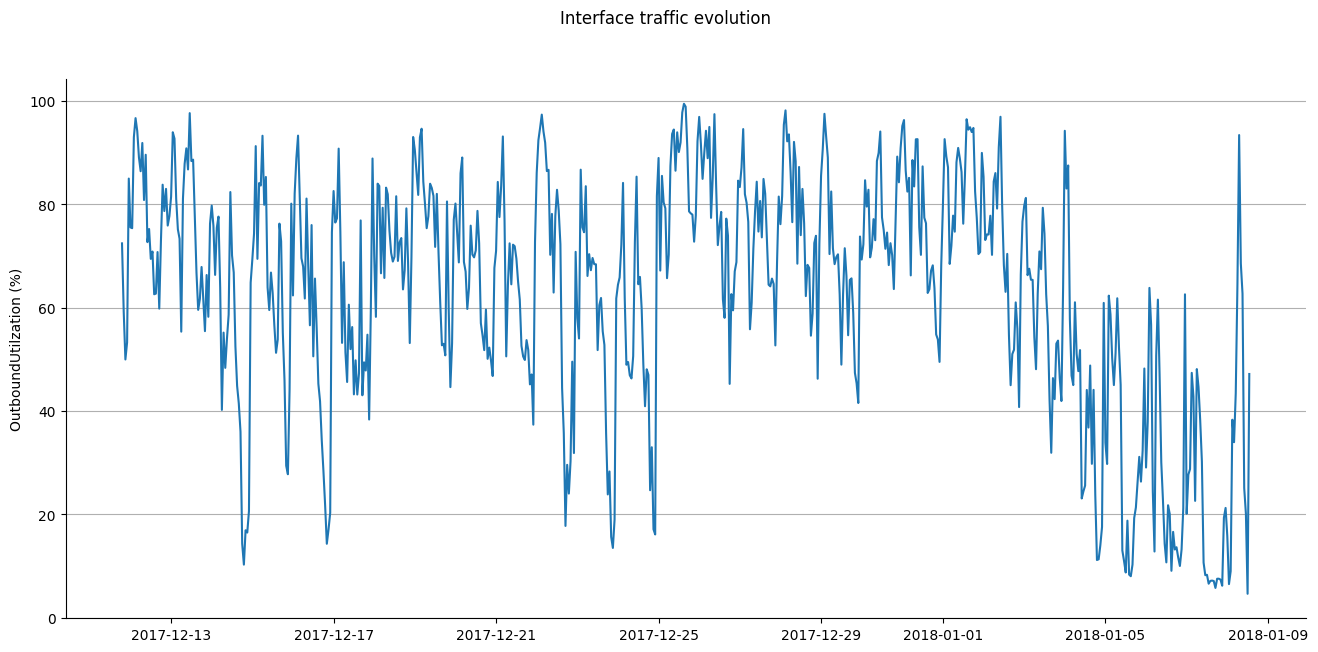

In [8]:
network_analytics_1H = network_analytics_new.resample('1H').mean()

x = network_analytics_1H.index[1500:]
y = network_analytics_1H[1500:]

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

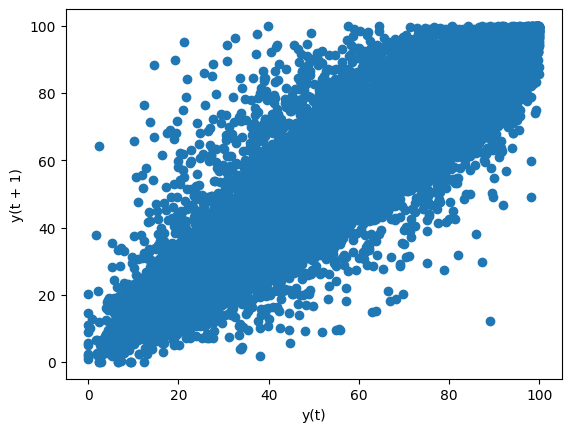

In [9]:
pd.plotting.lag_plot(series)

In [10]:
print(series.autocorr())

0.9229190122478939


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

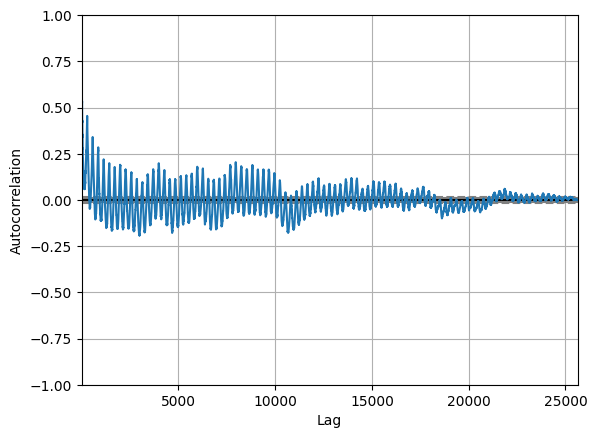

In [11]:
pd.plotting.autocorrelation_plot(series)

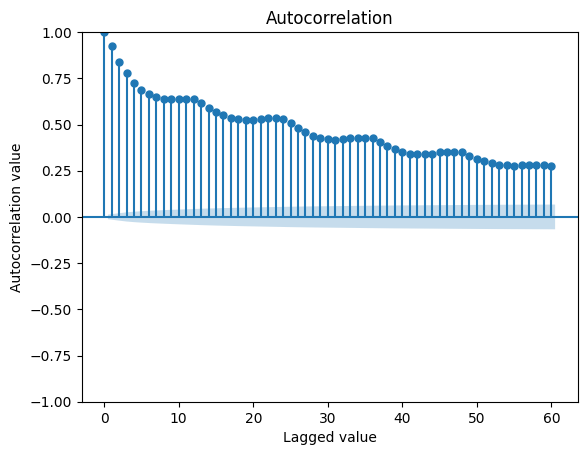

In [12]:
plot_acf(series, lags=60)
plt.ylabel("Autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

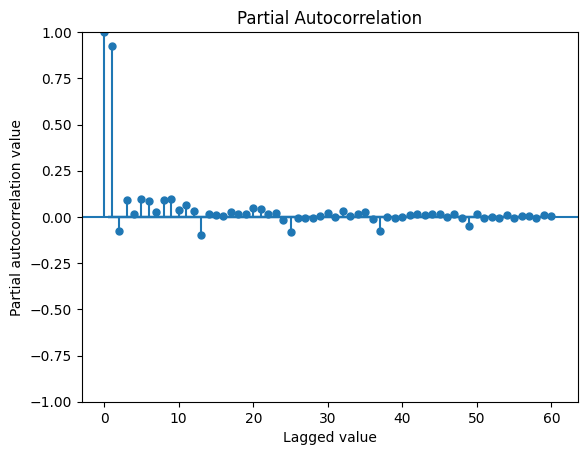

In [13]:
plot_pacf(series, lags=60)
plt.ylabel("Partial autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

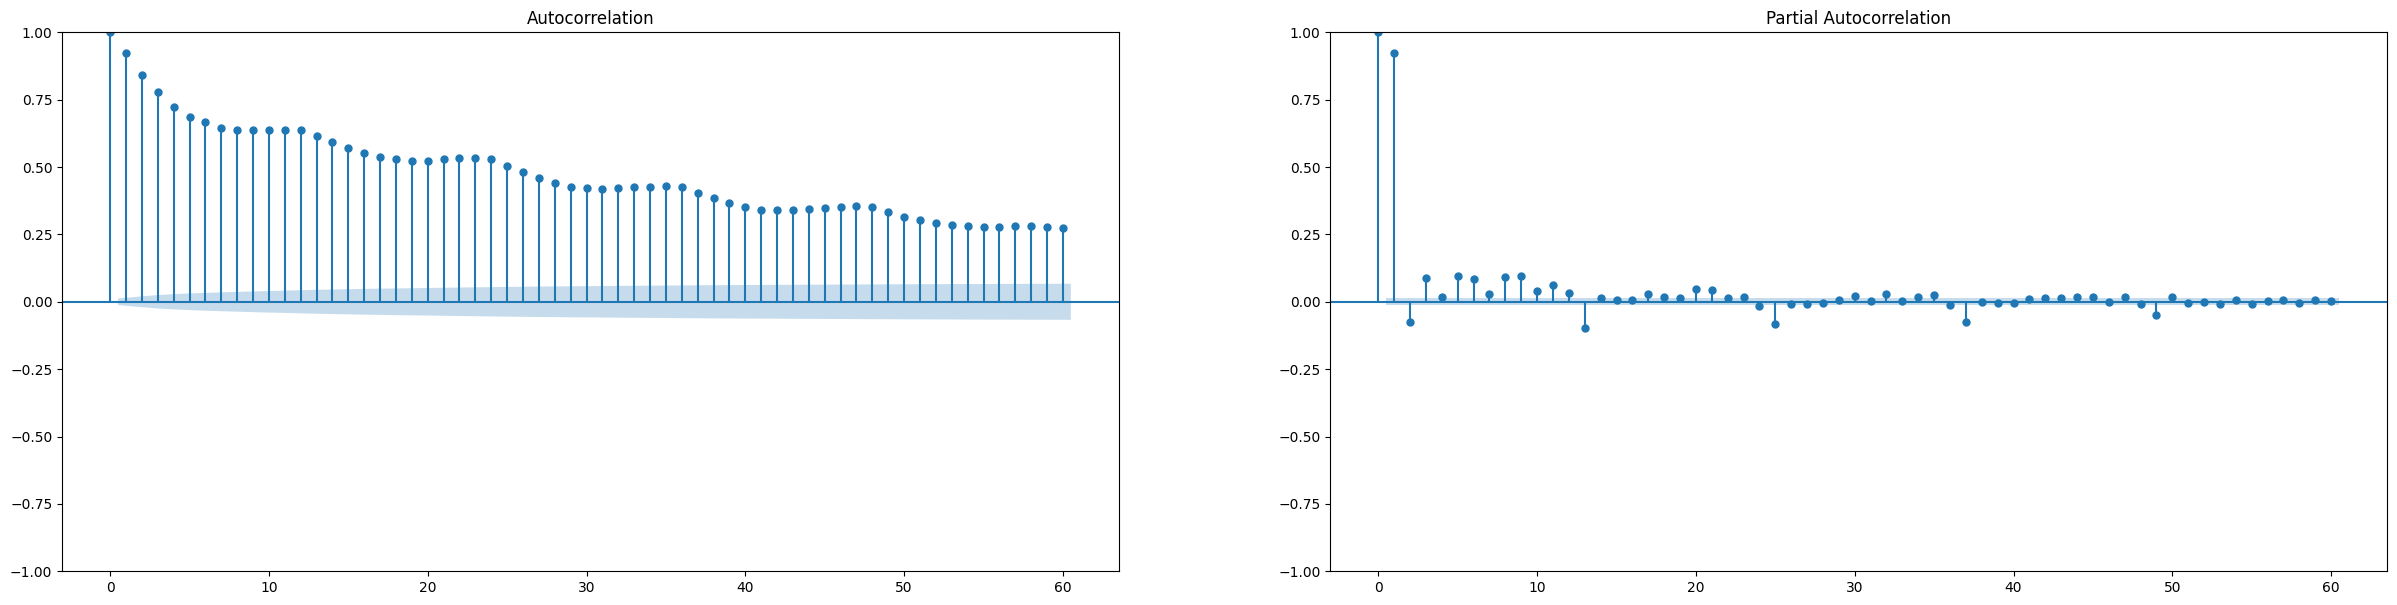

In [14]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

## Data preparation and utility function definition

In [15]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

In [16]:
def print_errors(usedlag, test, predictions):
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f"RMSE for {usedlag} lagged values: {rmse}")

    mape = mean_absolute_percentage_error(test, predictions)
    print(f"MAPE for {usedlag} lagged values: {mape}")

    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    print(f"SMAPE for {usedlag} lagged values: {smape}")

    mae = mean_absolute_error(test, predictions)
    print(f"MAE for {usedlag} lagged values: {mae}")

In [39]:
def plot_difference(test, predictions, dataset=network_analytics):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(dataset.index[-100:], test[len(test)- 100:], color='g', label='ground truth')
    ax.plot(dataset.index[-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
    plt.title('Difference between predicted and actual value')
    plt.xticks(dataset.index[-100::12])
    plt.legend(loc='best')
    plt.ylabel('OutboundUtilzation (%)')
    plt.xlabel('Timestamp')
    plt.show()

In [18]:
statistics, pval, ma_order, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {ma_order} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {ma_order} {nobs}")

Data is stationary -12.704162687630873 1.0639878489319919e-23 49 25581.


In [19]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

## MA model

In [20]:
MA_model = ARIMA(endog=train, order=(0, 0, ma_order))
if os.path.isfile('MA.pkl'):
    results = ARIMAResults.load('MA.pkl')
else:
    results = MA_model.fit()

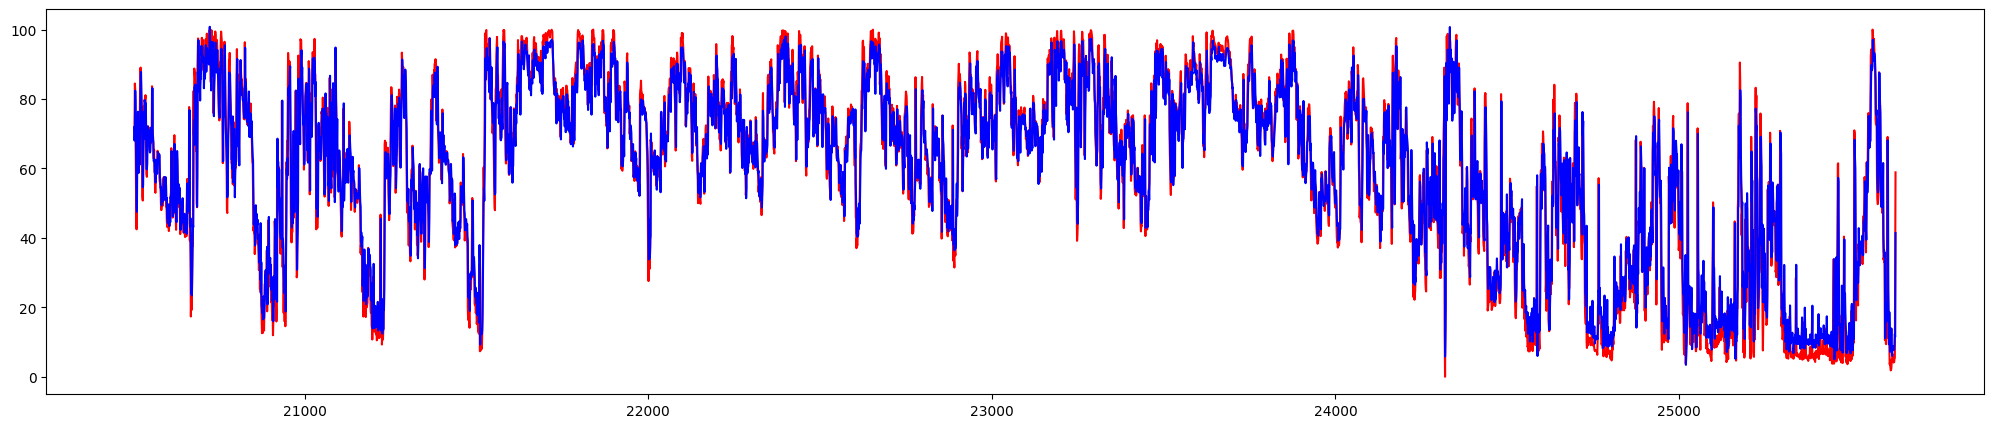

In [21]:
coef = results.params
# Grab last x values of the train dataset
history = train[len(train)-ma_order:]
# Compute their prediction
pred = results.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history - pred).tolist()

predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(ma_order):
        yhat += coef[d+1] * errors[ma_order-d-1]
        obs = X[t]
    predictions.append(yhat)

    errors.pop(0)
    errors.append(X[len(train) + t] - yhat)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(range(size, len(network_analytics)),network_analytics['OutboundUtilzation (%)'][size:len(network_analytics)], color='r')
ax.plot(range(size, len(network_analytics)), predictions, color='b')

In [22]:
print_errors(ma_order, test, predictions)

RMSE for 49 lagged values: 7.48907967599813
MAPE for 49 lagged values: 23.85254360374282
SMAPE for 49 lagged values: 13.250629379894555
MAE for 49 lagged values: 5.158979576575297


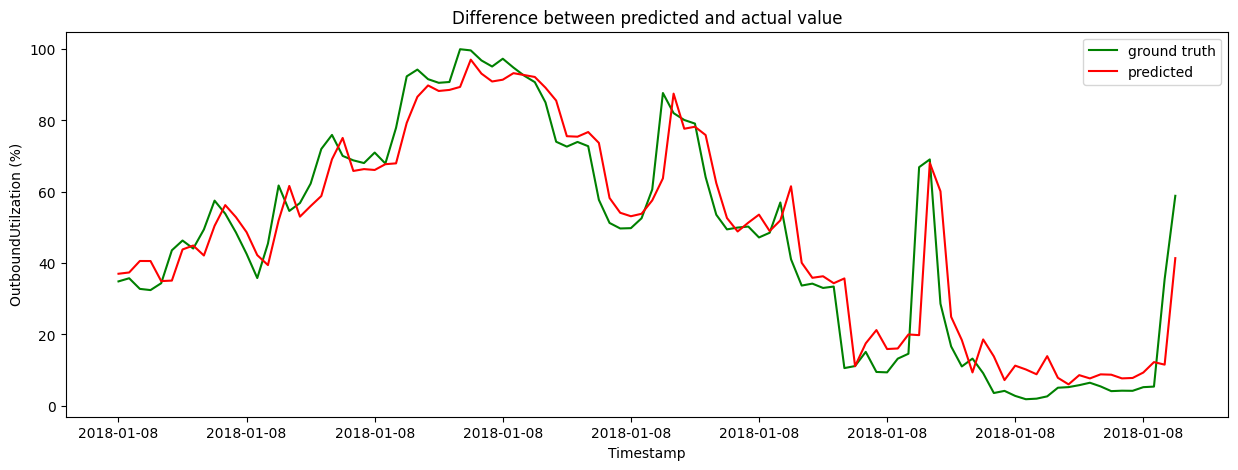

In [23]:
plot_difference(test, predictions)

## AR model

In [24]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(train, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

dir = 'output/information_criteria'
results = []
with concurrent.futures.ThreadPoolExecutor(5) as executor:
    futures = {executor.submit(worker_func, x): x for x in range(1, 100)}
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

results = sorted(results, key=lambda x : x[0])

with open(f"{dir}/criterions.json", 'w') as json_file:
    json.dump(results, json_file)

Processing 10 by thread 220916
Processing 20 by thread 220915
Processing 30 by thread 220914
Processing 40 by thread 220912
Processing 50 by thread 220914
Processing 60 by thread 220916
Processing 70 by thread 220915
Processing 80 by thread 220914
Processing 90 by thread 220912


3
(array([50, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),)
50
(array([0]),)
P Values:  [2.80443490e-31 1.90320928e-23 3.67680279e-01 1.54178872e-28
 2.83978750e-30 8.80449728e-07 7.23149265e-25 1.25576014e-28
 2.01199725e-06 1.57941880e-08 3.62589156e-09 3.61490103e-25
 1.13047722e-02 5.05420347e-02 1.14081099e-01 5.44502393e-02
 4.53327395e-01 4.65211198e-01 2.25404532e-02 2.92243188e-02
 4.09208523e-01 4.48302256e-01 4.22629432e-01 1.65942733e-10
 8.43542649e-01 8.92118535e-01 9.55756694e-01 8.57827113e-01
 7.35139438e-01 9.82480717e-01 9.20004188e-01 9.96328600e-01
 9.79359095e-01 7.99784761e-01 9.88331777e-01 2.61817951e-04
 9.99999814e-01 9.99999898e-01 9.99999931e-01 9.99999958e-01
 9.99999986e-01 9.99996602e-01 1.00000000e+00 9.99999979e-01
 1.00000000e+00 1.00000000e+00 9.99999999e-01 9.76684769e-01
 1.00000000e+00 1.00000000e+00 1.0000

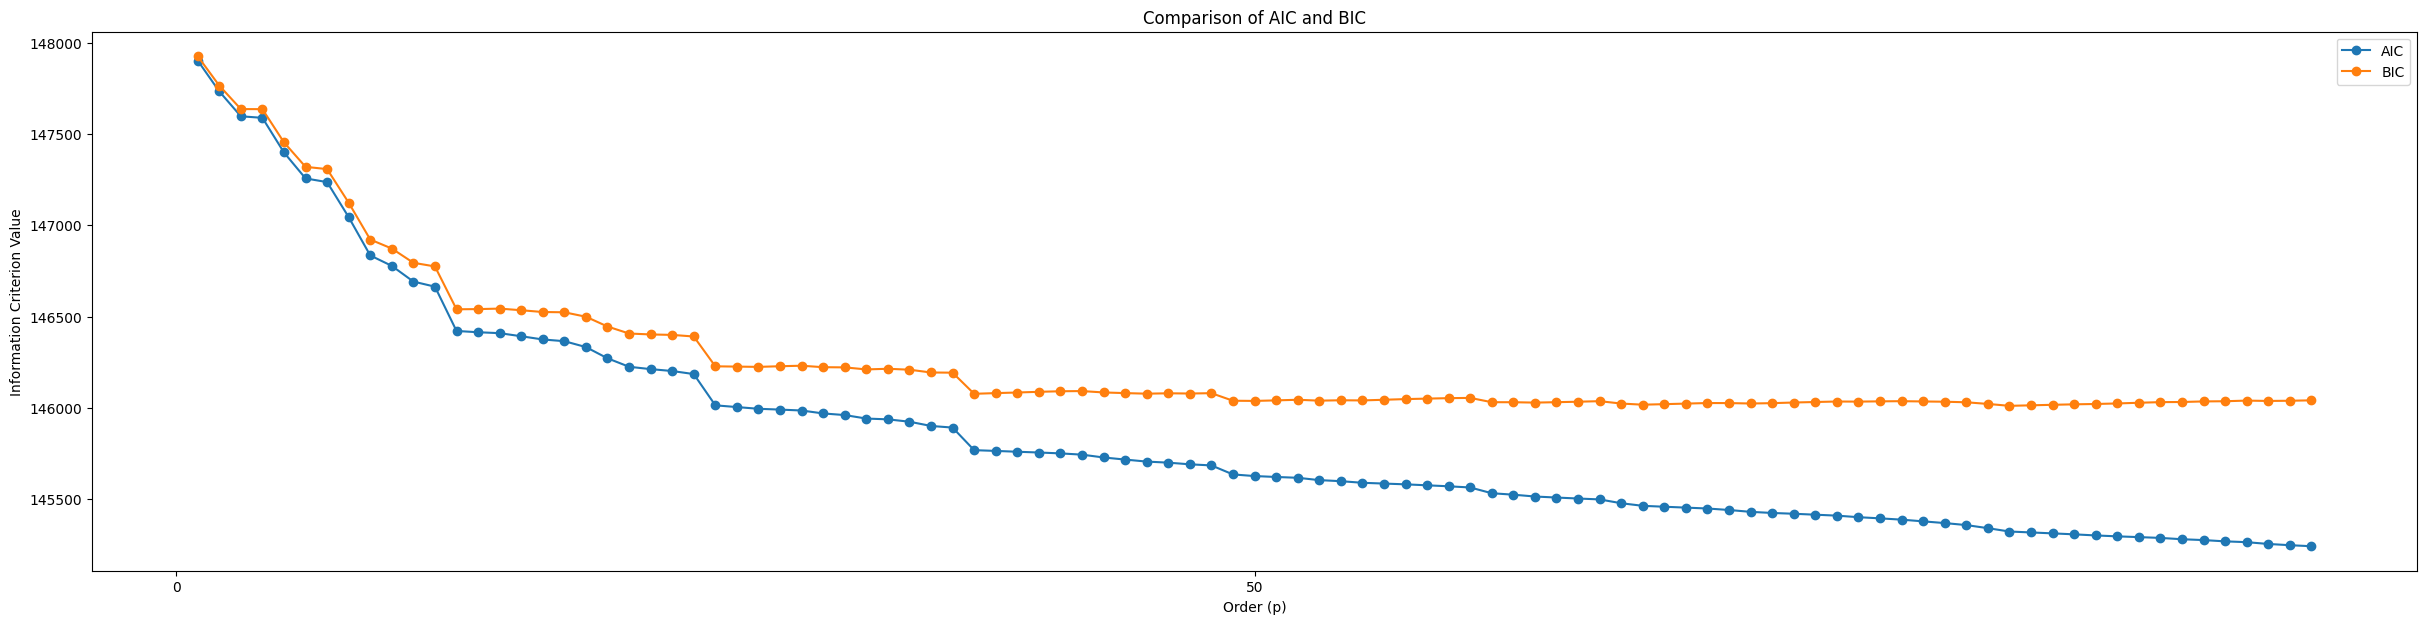

In [20]:
dir = 'output/information_criteria'

with open(f"{dir}/criterions.json", 'r') as json_file:
    data = json.load(json_file)
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
selected_order = np.argmax(np.array(p_values) > threshold) +  1
print(selected_order)
first_lag = np.where(p_values == 1)
print(first_lag)
print(first_lag[0][0])
min_lag = np.where(np.min(p_values))
print(min_lag)
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [21]:
ar_order = first_lag[0][0]

model = AutoReg(train, lags=ar_order)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-ar_order:].tolist()
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]
        obs = X[t]
    predictions.append(yhat)
    history.pop(0)
    history.append(obs)

In [22]:
print_errors(ar_order, test, predictions)

RMSE for 50 lagged values: 36.61796155257973
MAPE for 50 lagged values: 213.3069435092606
SMAPE for 50 lagged values: 57.90539664922411
MAE for 50 lagged values: 29.71060862389537


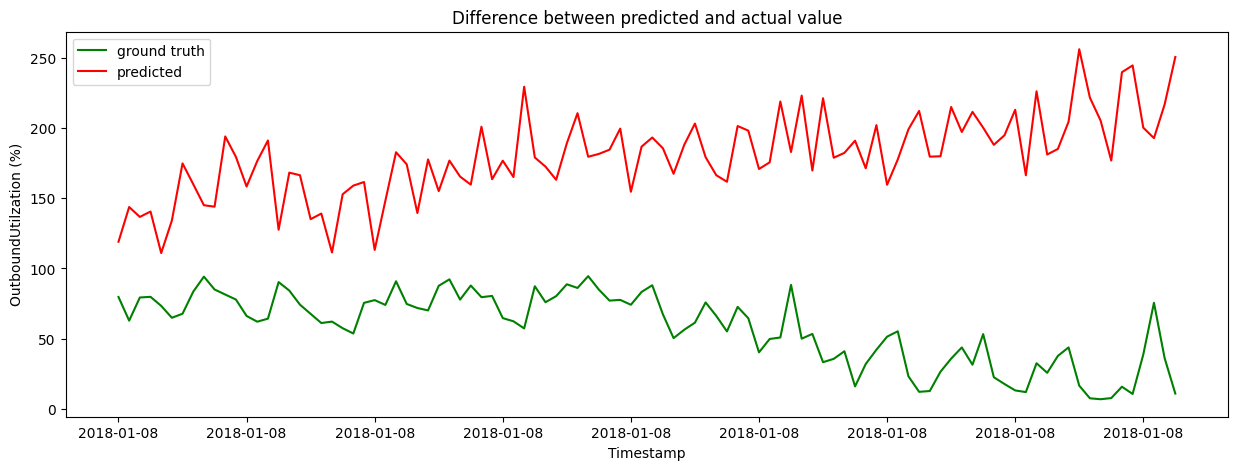

In [41]:
plot_difference(test, predictions)

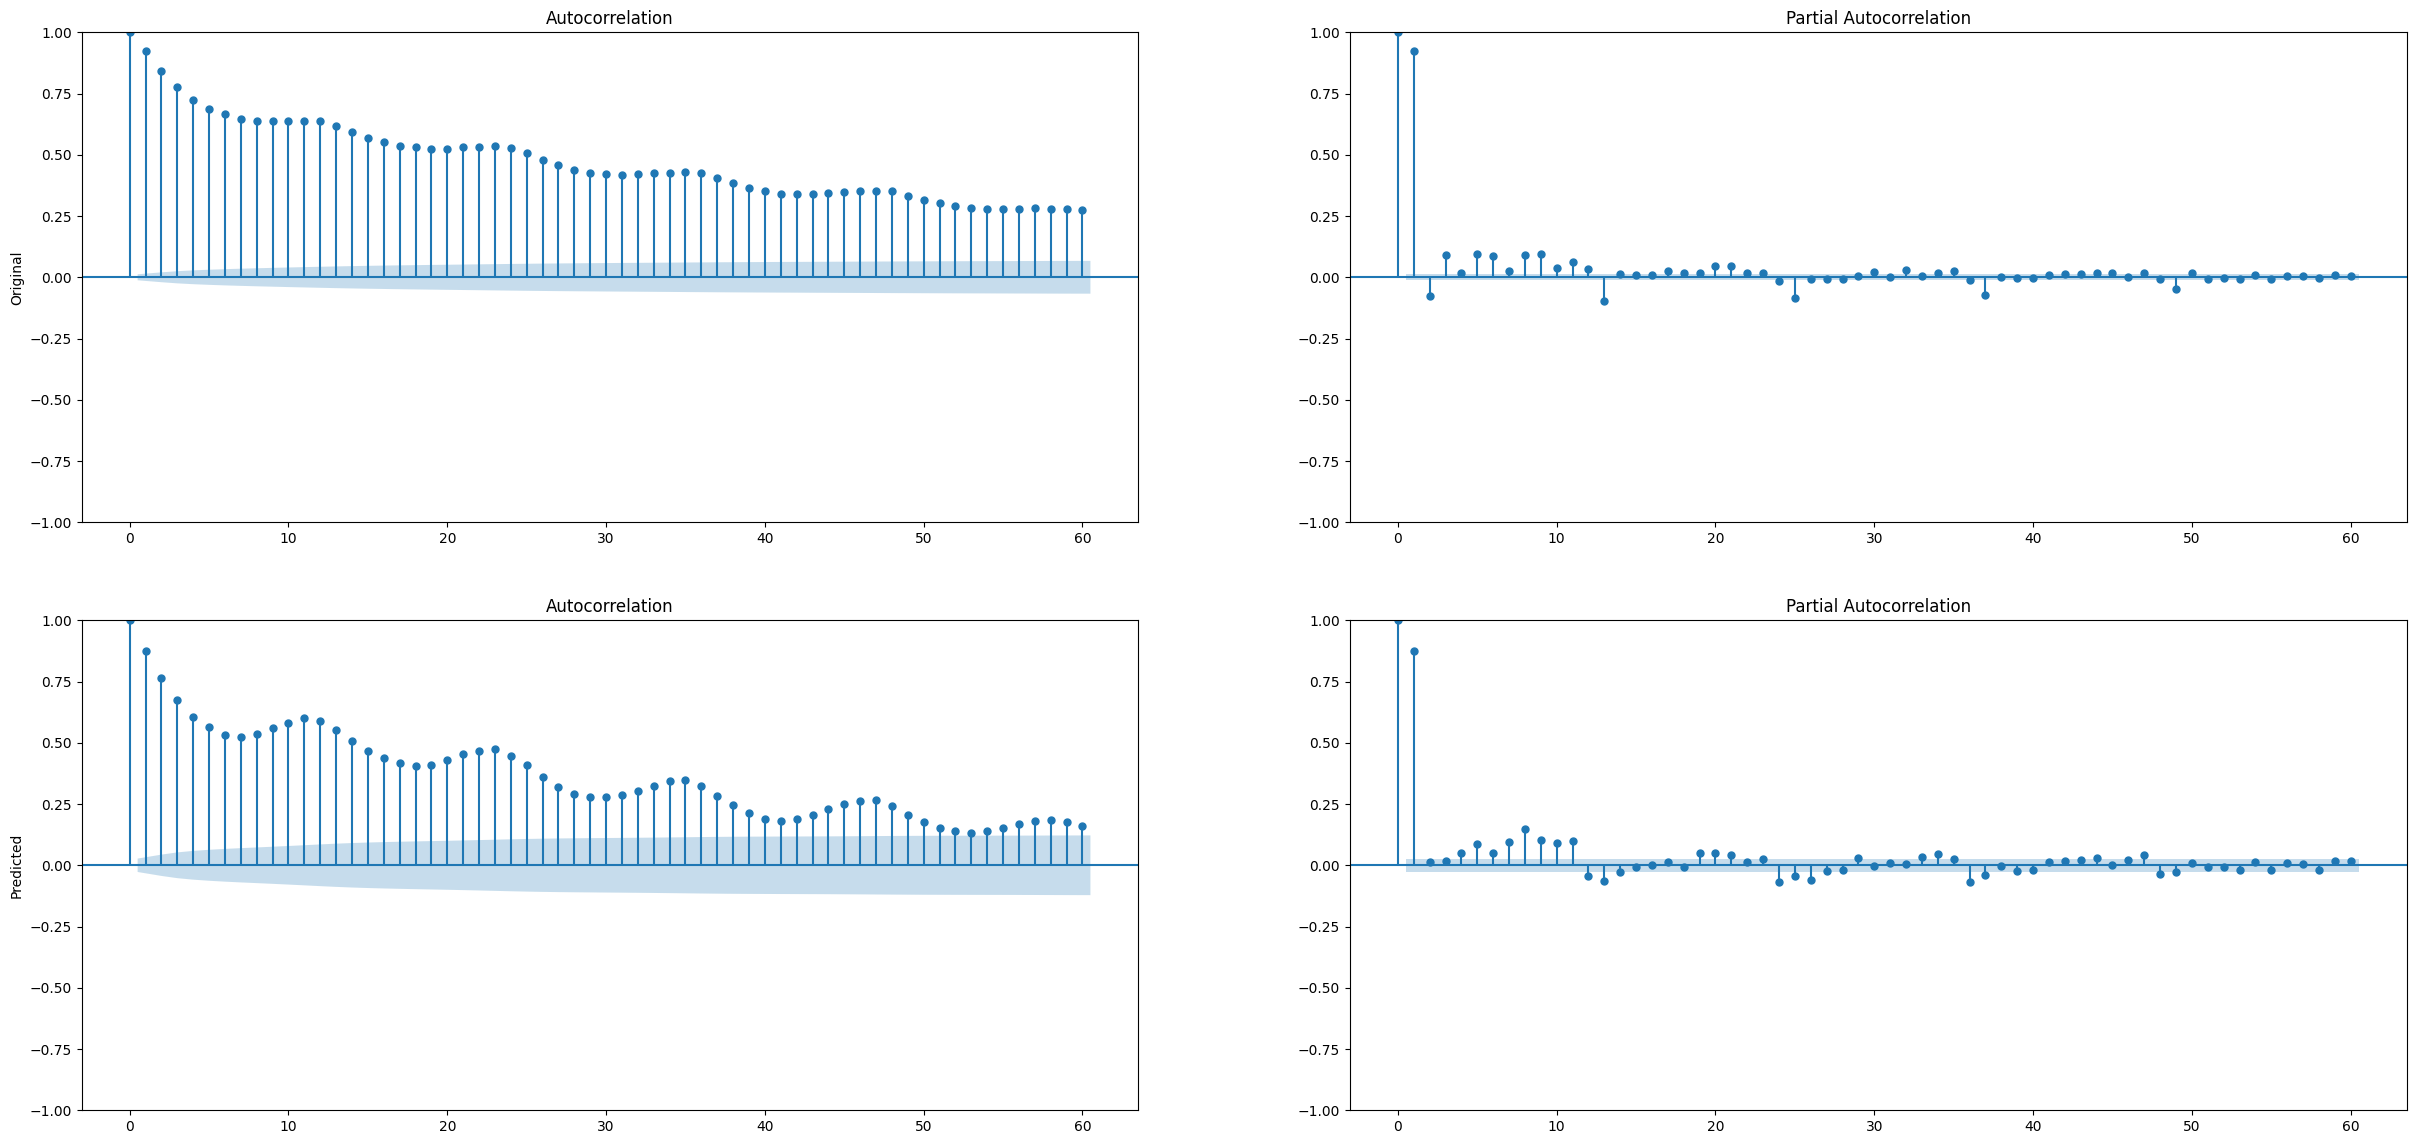

In [51]:
fig, ax = plt.subplots(2,2,figsize=(30,14))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(predictions, lags=60, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(predictions, lags=60, ax=ax[1, 1])
ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Predicted")
plt.show()

## ARIMA

In [47]:
# network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
# network_analytics = network_analytics.set_index('Timestamp')
# network_analytics_2H = network_analytics.resample('2H').mean()
# series = pd.Series(network_analytics_2H['OutboundUtilzation (%)'].values)

X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [48]:
model = ARIMA(train, order=(ar_order, 0, ma_order))
model_fit = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
model_fit.save('ARIMA_new.pkl')

In [50]:
coef = model_fit.params
history = train[len(train)-ar_order:].tolist()

history_ma = train[len(train)-ma_order:].tolist()
pred = model_fit.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history_ma - pred).tolist()

predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]

    for d in range(ma_order):
        yhat += coef[d+ar_order+1] * errors[ma_order-d-1]

    errors.pop(0)
    errors.append(test[t] - yhat)
    predictions.append(yhat)
    history.pop(0)
    history.append(test[t])

In [51]:
print_errors(f"ARIMA({ar_order}, 0, {ma_order})", test, predictions)

RMSE for ARIMA(50, 0, 49) lagged values: 11.30476726152828
MAPE for ARIMA(50, 0, 49) lagged values: 97.87915513250405
SMAPE for ARIMA(50, 0, 49) lagged values: 21.991268244969234
MAE for ARIMA(50, 0, 49) lagged values: 8.10520100648724


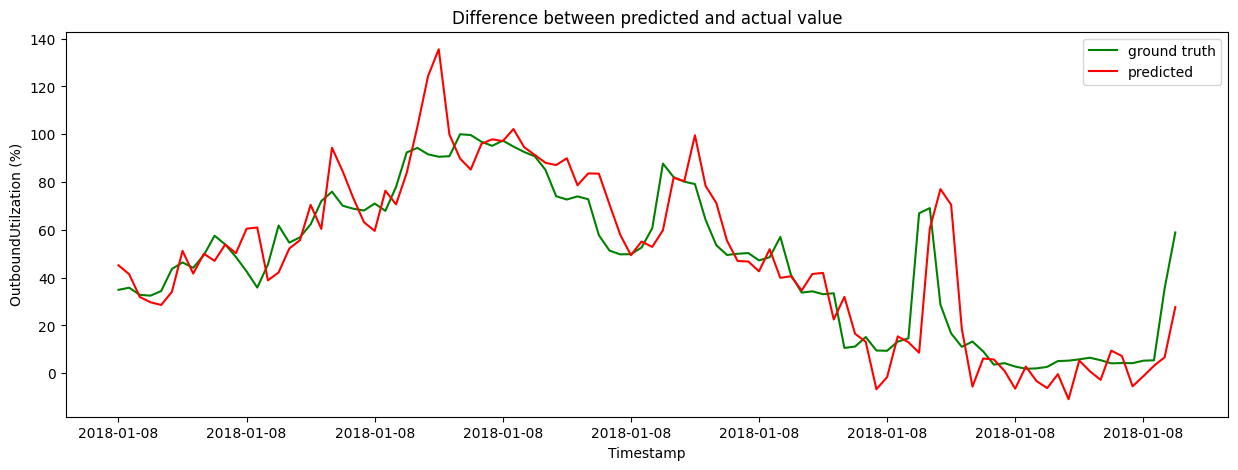

In [52]:
plot_difference(test, predictions)

## CNN

In [ ]:
train_len = int(len(network_analytics) * 0.80)
valid_len = int(len(network_analytics) * 0.15)

train = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

assert len(network_analytics) == (len(train) + len(valid) + len(test))

print('Proportion of train_set : {:.2f}%'.format(len(train)/len(network_analytics) * 100))
print('Proportion of valid_set : {:.2f}%'.format(len(valid)/len(network_analytics) * 100))
print('Proportion of test_set : {:.2f}%'.format(len(test)/len(network_analytics) * 100))

In [ ]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train['OutboundUtilzation (%)'].values,n_steps)
valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values,n_steps)
test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values,n_steps)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label